In [1]:
import numpy as np
import joblib
import xgboost as xgb

from acpi import utils

In [2]:
class XGBoostACPIWrapper:
    """ACPI wrapper for an XGBoost model."""

    def __init__(self, model):
        self.model = model

    def predict(self, X):
        """Predict using the XGBoost model, handling DMatrix conversion."""
        dmatrix = xgb.DMatrix(X)
        return self.model.predict(dmatrix)

In [3]:
# load the acpi model
acpi_model = joblib.load("./models/acpi_xgboost_model_1.pkl")

C:\Users\joobzm\AppData\Local\Programs\Python\Python311\Lib\pickle.py:1718: UserWarning: [18:09:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\data\../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)
C:\Users\joobzm\Desktop\TDK\ACPI\.venv11\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.5.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limi

In [4]:
DATA_TRAIN_PATH = "../data/train.csv"
DATA_TEST_PATH = "../data/test.csv"
target_col = "count"
context_length = 24

In [5]:
train_df = utils.read_bike_data(DATA_TRAIN_PATH)
test_df = utils.read_bike_data(DATA_TEST_PATH)
feature_cols = [c for c in train_df.columns if c != target_col and c in test_df.columns]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_features = scaler.fit_transform(train_df[feature_cols].values.astype(np.float32))
train_target = train_df[target_col].values.astype(np.float32)

# Windowed supervised data
X_all, y_all = utils.build_lag_supervised(train_features, train_target, context_length)

# Time-ordered splits: model train / holdout
train_ratio = 0.8
n_train = int(len(X_all) * train_ratio)
X_test_hold, y_test_hold = X_all[n_train:], y_all[n_train:]

cal_size = 0.5
n_cal = int(len(X_test_hold) * cal_size)
X_test_acpi, y_test_acpi = X_test_hold[n_cal:], y_test_hold[n_cal:]

# Point predictions from the wrapped base model inside ACPI
predictions = acpi_model.model_cali.predict(X_test_acpi)

In [6]:
y_lower, y_upper =  acpi_model.predict_pi(X_test_acpi, method='qrf')

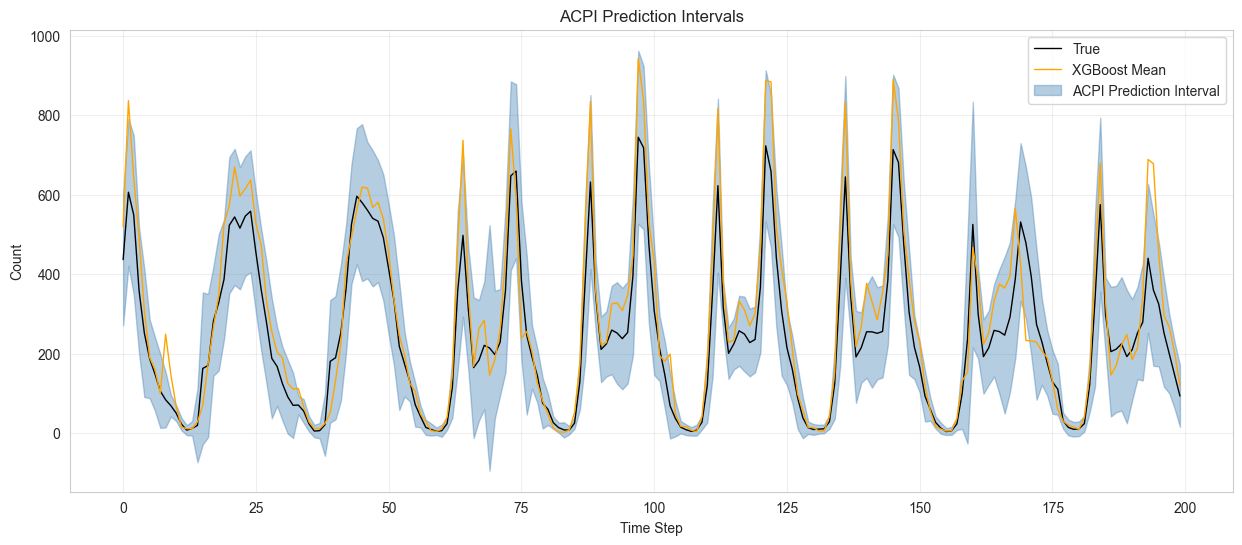

(<Figure size 1500x600 with 1 Axes>,
 <Axes: title={'center': 'ACPI Prediction Intervals'}, xlabel='Time Step', ylabel='Count'>)

In [7]:
utils.plot_acpi_predictions(predictions, y_test_acpi, y_lower, y_upper)

In [8]:
# Evaluate the model
mse = np.mean((predictions - y_test_acpi) ** 2)
mae = np.mean(np.abs(predictions - y_test_acpi))
rmse = np.sqrt(mse)
mape = np.mean(np.abs((predictions - y_test_acpi) / y_test_acpi
                    )) * 100  # Mean Absolute Percentage Error
r2 = 1 - (np.sum((y_test_acpi - predictions) ** 2) / np.sum((y_test_acpi - np.mean(y_test_acpi)) ** 2))
print(f"Mean Squared Error: {mse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Percentage Error: {mape:.2f}%")
print(f"R^2 Score: {r2:.2f}")

Mean Squared Error: 4562.06
Mean Absolute Error: 44.85
Root Mean Squared Error: 67.54
Mean Absolute Percentage Error: 37.47%
R^2 Score: 0.88


In [9]:
# get coverage
coverage = utils.compute_coverage(y_test_acpi, y_lower, y_upper)
print(f"Coverage: {coverage:.2f}")


Coverage: 0.94


# Generative CP model

In [10]:
# Generative CP model
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import scipy.stats as _scistats
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


class GenerativeCounterfactualGenerator:
    """
    Generative counterfactual generator using a variational autoencoder (VAE).
    This version is adapted for black-box models that produce prediction intervals.
    It uses a "generate-and-test" approach instead of gradient-based optimization.
    """

    def __init__(self, prediction_model, device, alpha=0.1, latent_dim=16):
        self.prediction_model = prediction_model
        self.device = device
        self.alpha = alpha
        # z-score for the given alpha, e.g., 1.645 for alpha=0.1 (90% interval)
        self.z = float(_scistats.norm.ppf(1 - alpha / 2.0))
        self.latent_dim = latent_dim
        self.vae = None
        self.is_trained = False

    def _build_vae(self, input_dim):
        """Build VAE for learning sequence representations."""

        class SequenceVAE(nn.Module):
            def __init__(self, input_dim, latent_dim, hidden_dim=128):
                super().__init__()
                self.input_dim = input_dim
                self.latent_dim = latent_dim

                # Encoder
                self.encoder = nn.Sequential(
                    nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Dropout(0.1),
                    nn.Linear(hidden_dim, hidden_dim // 2), nn.ReLU(), nn.Dropout(0.1)
                )
                self.mu_layer = nn.Linear(hidden_dim // 2, latent_dim)
                self.logvar_layer = nn.Linear(hidden_dim // 2, latent_dim)

                # Decoder
                self.decoder = nn.Sequential(
                    nn.Linear(latent_dim, hidden_dim // 2), nn.ReLU(), nn.Dropout(0.1),
                    nn.Linear(hidden_dim // 2, hidden_dim), nn.ReLU(), nn.Dropout(0.1),
                    nn.Linear(hidden_dim, input_dim)
                )
                self.apply(self._init_weights)

            def _init_weights(self, module):
                if isinstance(module, nn.Linear):
                    torch.nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        torch.nn.init.zeros_(module.bias)

            def encode(self, x):
                h = self.encoder(x)
                mu, logvar = self.mu_layer(h), self.logvar_layer(h)
                return mu, torch.clamp(logvar, min=-10, max=10)

            def reparameterize(self, mu, logvar):
                std = torch.exp(0.5 * logvar)
                eps = torch.randn_like(std)
                return mu + eps * std

            def decode(self, z):
                return self.decoder(z)

            def forward(self, x):
                mu, logvar = self.encode(x)
                z = self.reparameterize(mu, logvar)
                recon = self.decode(z)
                return recon, mu, logvar, z

        return SequenceVAE(input_dim, self.latent_dim).to(self.device)

    def train_vae(self, X_sequences, epochs=200, batch_size=64, lr=1e-3, beta=0.1):
        """Train VAE on sequence data."""
        print("Training generative model (VAE)...")
        X_sequences = np.asarray(X_sequences, dtype=np.float32)

        # Normalize input data for VAE stability
        self.mean_X = np.mean(X_sequences, axis=0, keepdims=True)
        self.std_X = np.std(X_sequences, axis=0, keepdims=True) + 1e-8
        X_normalized = (X_sequences - self.mean_X) / self.std_X

        input_dim = X_sequences.shape[1]
        self.vae = self._build_vae(input_dim)
        optimizer = torch.optim.Adam(self.vae.parameters(), lr=lr, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.8)
        dataset = TensorDataset(torch.tensor(X_normalized, dtype=torch.float32))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.vae.train()
        for epoch in range(epochs):
            total_loss = 0
            for (batch_x,) in dataloader:
                batch_x = batch_x.to(self.device)
                optimizer.zero_grad()
                recon, mu, logvar, _ = self.vae(batch_x)
                recon_loss = nn.functional.mse_loss(recon, batch_x, reduction='mean')
                kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
                loss = recon_loss + beta * kl_loss
                if torch.isnan(loss): continue
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.vae.parameters(), max_norm=1.0)
                optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            scheduler.step(avg_loss)
            if (epoch + 1) % 50 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, VAE Loss: {avg_loss:.4f}")

        self.vae.eval()
        self.is_trained = True
        print("VAE training completed.")

    def _normalize_input(self, x):
        return (x - self.mean_X) / self.std_X

    def _denormalize_output(self, x_norm):
        return x_norm * self.std_X + self.mean_X

    def generate_diverse(self, x_orig, y_true, n_samples=5000, exploration_std=0.5, lower_bounds=None,
                         upper_bounds=None, immutable_mask=None):
        """
        Generate diverse counterfactuals using a 'generate-and-test' approach.
        This method samples from the VAE's latent space and checks each sample
        with the black-box ACPI model.
        """
        if not self.is_trained:
            raise ValueError("VAE must be trained first. Call train_vae().")

        x_orig_np = np.asarray(x_orig, dtype=np.float32)
        x_orig_norm = self._normalize_input(x_orig_np)
        x_orig_t = torch.tensor(x_orig_norm, device=self.device, dtype=torch.float32)

        # Encode original sequence to its latent representation
        with torch.no_grad():
            mu_orig, _ = self.vae.encode(x_orig_t.unsqueeze(0))
            if torch.isnan(mu_orig).any():
                print("Warning: NaN in encoding, using zero latent vector.")
                mu_orig = torch.zeros_like(mu_orig)

        successful_cfs = []
        for _ in range(n_samples):
            # 1. GENERATE: Sample from latent space and decode
            with torch.no_grad():
                z_sample = mu_orig + exploration_std * torch.randn_like(mu_orig)
                x_cf_norm = self.vae.decode(z_sample).squeeze(0)

            # Denormalize and apply constraints
            x_cf_denorm = x_cf_norm.cpu().numpy() * self.std_X + self.mean_X
            x_cf_denorm = x_cf_denorm.flatten()  # Ensure 1D shape

            if lower_bounds is not None:
                x_cf_denorm = np.maximum(x_cf_denorm, lower_bounds)
            if upper_bounds is not None:
                x_cf_denorm = np.minimum(x_cf_denorm, upper_bounds)
            if immutable_mask is not None:
                x_cf_denorm[immutable_mask] = x_orig_np[immutable_mask]

            # 2. TEST: Check if the sample is a valid counterfactual
            # Reshape for the ACPI model which expects (n_samples, n_features)
            x_cf_input = x_cf_denorm.reshape(1, -1)
            y_lower_cf, y_upper_cf = self.prediction_model.predict_pi(x_cf_input, method='qrf')

            # A counterfactual is valid if the original true value y_true is
            # outside the new prediction interval.
            is_cf = not (y_lower_cf[0] <= y_true <= y_upper_cf[0])

            if is_cf:
                # Calculate the margin (how far y_true is from the interval)
                prediction_cf = (y_lower_cf[0] + y_upper_cf[0]) / 2
                half_width_cf = (y_upper_cf[0] - y_lower_cf[0]) / 2
                margin = abs(prediction_cf - y_true) - half_width_cf

                cf_result = {
                    "x_cf": x_cf_denorm,
                    "margin": margin,
                    "l1_distance": float(np.abs(x_cf_denorm - x_orig_np).sum()),
                    "l2_distance": float(np.linalg.norm(x_cf_denorm - x_orig_np)),
                }
                successful_cfs.append(cf_result)

        if not successful_cfs:
            return {"status": "fail_no_counterfactuals", "n_successful": 0, "counterfactuals": []}

        # Sort by margin (strongest counterfactuals first) and return
        successful_cfs.sort(key=lambda item: item["margin"], reverse=True)
        return {
            "status": "success", "n_successful": len(successful_cfs),
            "counterfactuals": successful_cfs, "x_orig": x_orig_np, "y_true": float(y_true)
        }

    def plot_diverse_counterfactuals(self, result, max_plot=5, figsize=(12, 8), change_threshold=1e-3, zoom=None):
        """Plot original vs. diverse counterfactual sequences with optional zoom."""
        if result.get("status") != "success":
            print(f"No counterfactuals to plot (status={result.get('status')})")
            return

        x_orig = result["x_orig"].flatten()
        cfs = result["counterfactuals"][:max_plot]
        if not cfs:
            print("Empty counterfactual list.")
            return

        # Apply zoom if specified
        if zoom is not None:
            start, end = zoom
            x_orig = x_orig[start:end]
            t = np.arange(start, end)
        else:
            t = np.arange(len(x_orig))

        fig, axes = plt.subplots(len(cfs), 1, figsize=figsize, sharex=True, squeeze=False)
        axes = axes.flatten()

        for i, cf in enumerate(cfs):
            ax = axes[i]
            cf_seq = cf["x_cf"].flatten()

            # Apply zoom to counterfactual sequence
            if zoom is not None:
                cf_seq = cf_seq[start:end]

            ax.plot(t, x_orig, color="tab:blue", label="Original", linewidth=1.3, alpha=0.85)
            ax.plot(t, cf_seq, color="tab:orange", label=f"CF {i + 1}")

            changed_mask = np.abs(cf_seq - x_orig) > change_threshold
            if changed_mask.any():
                ax.scatter(t[changed_mask], cf_seq[changed_mask], color="red", s=15, zorder=5, label="Changed pts")

            ax.set_ylabel("Value")
            ax.set_title(f"CF {i + 1}: margin={cf['margin']:.3f}, L1 Dist={cf['l1_distance']:.2f}")
            ax.grid(True, alpha=0.3)
            if i == 0:
                ax.legend(loc="upper left")

        axes[-1].set_xlabel("Feature Index (Time Lag)")
        fig.suptitle("Diverse Counterfactual Explanations", y=0.99)
        fig.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
        return fig

In [11]:
import random
import torch

# --- Setup for the Generative Model ---
# Define alpha (significance level) and compute device
alpha = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Correctly reference the training data for the VAE
X_train_acpi = X_all[:n_train]

print("\n" + "=" * 50)
print("Generative-based Counterfactual Example")
print("=" * 50)

# --- Find an instance to explain ---
# We want to explain why a prediction was "correct" (i.e., the true value was
# inside the prediction interval). A counterfactual will show what minimal
# change would have made the prediction "incorrect".
covered_indices = np.where((y_test_acpi >= y_lower) & (y_test_acpi <= y_upper))[0]

if len(covered_indices) > 0:
    idx_to_explain = random.choice(covered_indices)
    x_instance = X_test_acpi[idx_to_explain]
    y_instance = y_test_acpi[idx_to_explain]

    print(f"Selected instance {idx_to_explain} for generative counterfactual analysis.")
    print(f"Original input sequence (last 5 values): ...{np.round(x_instance[-5:], 2)}")
    print(f"True future value (y): {y_instance:.2f}")

    # --- Train VAE and Generate Counterfactuals ---
    # 1. Instantiate the generator with the ACPI model
    gen_cf = GenerativeCounterfactualGenerator(
        prediction_model=acpi_model,
        device=device,
        alpha=alpha,
        latent_dim=16
    )

    # 2. Train the VAE to learn the structure of the input data
    gen_cf.train_vae(X_train_acpi, epochs=500, batch_size=128, lr=1e-3, beta=0.1)



Using device: cpu

Generative-based Counterfactual Example
Selected instance 1025 for generative counterfactual analysis.
Original input sequence (last 5 values): ...[-0.01 -0.37 -1.5   1.59  1.  ]
True future value (y): 135.00
Training generative model (VAE)...
Epoch 50/500, VAE Loss: 0.4092
Epoch 100/500, VAE Loss: 0.3908
Epoch 150/500, VAE Loss: 0.3810
Epoch 200/500, VAE Loss: 0.3755
Epoch 250/500, VAE Loss: 0.3696
Epoch 300/500, VAE Loss: 0.3654
Epoch 350/500, VAE Loss: 0.3619
Epoch 400/500, VAE Loss: 0.3604
Epoch 450/500, VAE Loss: 0.3544
Epoch 500/500, VAE Loss: 0.3521
VAE training completed.


In [12]:
# 3. Generate diverse counterfactuals using the trained VAE
print("\nGenerating counterfactuals...")
gen_result = gen_cf.generate_diverse(
    x_instance,
    y_instance,
    n_samples=10000,  # Generate-and-test requires more samples
    exploration_std=0.05,  # How far to explore in latent space
    lower_bounds=-2.0  # Example constraint: features can't be negative
)

print(f"Generation status: {gen_result['status']}")
print(f"Found {gen_result.get('n_successful')} successful counterfactuals.")

# 4. Plot the results
if gen_result['status'] == 'success':
    _ = gen_cf.plot_diverse_counterfactuals(gen_result, max_plot=3)

else:
    print("No covered instances found in the test set to generate counterfactuals for.")


Generating counterfactuals...
Generation status: fail_no_counterfactuals
Found 0 successful counterfactuals.
No covered instances found in the test set to generate counterfactuals for.


In [13]:
# zoom in on the last 24 hours
if gen_result['status'] == 'success':
    _ = gen_cf.plot_diverse_counterfactuals(gen_result, max_plot=3
, figsize=(12, 6), change_threshold=0.05, zoom=(100, 200))

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_cf_heatmaps_generative(x_orig_row, x_cf_row, context_length, feature_names=None, title_prefix=""):
    """Enhanced heatmap visualization for generative counterfactuals."""
    x_orig_row = np.asarray(x_orig_row).reshape(-1)
    x_cf_row = np.asarray(x_cf_row).reshape(-1)
    assert x_orig_row.shape == x_cf_row.shape, "Original and CF row must have same shape"
    d = x_orig_row.size

    if d % context_length == 0:
        base_dim = d // context_length
        feats = feature_names if feature_names and len(feature_names) == base_dim else [f"f{j}" for j in range(base_dim)]
        Xo = x_orig_row.reshape(context_length, base_dim)
        Xc = x_cf_row.reshape(context_length, base_dim)
        Xd = Xc - Xo

        fig, axes = plt.subplots(1, 3, figsize=(16, 4), constrained_layout=True)

        # Original heatmap
        sns.heatmap(Xo, ax=axes[0], cmap="viridis", cbar_kws={'label': 'Feature Value'})
        axes[0].set_title(f"{title_prefix}Original")
        axes[0].set_xlabel("Feature")
        axes[0].set_ylabel("Time Lag (t-N to t-1)")
        axes[0].set_xticks(np.arange(base_dim) + 0.5)
        axes[0].set_xticklabels(feats, rotation=45, ha='right')

        # Counterfactual heatmap
        sns.heatmap(Xc, ax=axes[1], cmap="viridis", cbar_kws={'label': 'Feature Value'})
        axes[1].set_title(f"{title_prefix}Counterfactual")
        axes[1].set_xlabel("Feature")
        axes[1].set_ylabel("Time Lag (t-N to t-1)")
        axes[1].set_xticks(np.arange(base_dim) + 0.5)
        axes[1].set_xticklabels(feats, rotation=45, ha='right')

        # Delta heatmap
        v = np.max(np.abs(Xd))
        sns.heatmap(Xd, ax=axes[2], cmap="RdBu_r", center=0, vmin=-v, vmax=v,
                   cbar_kws={'label': 'Change (CF - Orig)'})
        axes[2].set_title(f"{title_prefix}Delta (CF - Orig)")
        axes[2].set_xlabel("Feature")
        axes[2].set_ylabel("Time Lag (t-N to t-1)")
        axes[2].set_xticks(np.arange(base_dim) + 0.5)
        axes[2].set_xticklabels(feats, rotation=45, ha='right')

        plt.show()

        # Per-feature aggregate delta plot
        agg = np.mean(np.abs(Xd), axis=0)
        plt.figure(figsize=(12, 4))
        bars = plt.bar(np.arange(base_dim), agg, color='steelblue', alpha=0.7)
        plt.title(f"{title_prefix}Mean |Change| per Feature")
        plt.xlabel("Feature")
        plt.ylabel("Mean Absolute Change")
        plt.xticks(np.arange(base_dim), feats, rotation=45, ha='right')

        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01*max(agg),
                    f'{height:.3f}', ha='center', va='bottom')

        plt.grid(True, axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

def plot_single_feature_generative(x_orig, x_cf, feature, context_length, feature_names=None, instance_name=None):
    """Plot single feature trajectory for generative counterfactuals."""
    x_o = np.asarray(x_orig).flatten()
    x_c = np.asarray(x_cf).flatten()
    title_suffix = f" for {instance_name}" if instance_name else ""

    total_dim = x_o.size
    assert total_dim % context_length == 0, "Vector size is not divisible by context_length."
    base_dim = total_dim // context_length

    if feature_names is None:
        feature_names = [f"feature_{j}" for j in range(base_dim)]

    if isinstance(feature, str):
        if feature not in feature_names:
            raise ValueError(f"Feature '{feature}' not found in feature_names.")
        feat_idx = feature_names.index(feature)
    else:
        feat_idx = int(feature)
        if not (0 <= feat_idx < base_dim):
            raise ValueError(f"Feature index {feat_idx} out of bounds.")

    Xo_reshaped = x_o.reshape(context_length, base_dim)
    Xc_reshaped = x_c.reshape(context_length, base_dim)

    original_series = Xo_reshaped[:, feat_idx]
    cf_series = Xc_reshaped[:, feat_idx]
    delta_series = cf_series - original_series

    time_lags = np.arange(context_length)
    feature_display_name = feature_names[feat_idx]

    # Trajectory plot
    plt.figure(figsize=(12, 5))
    plt.plot(time_lags, original_series, 'o-', label="Original", markersize=5, color='blue')
    plt.plot(time_lags, cf_series, 's--', label="Counterfactual", markersize=5, color='red')
    plt.fill_between(time_lags, original_series, cf_series, alpha=0.2, color='gray')
    plt.title(f"Feature Trajectory: '{feature_display_name}'{title_suffix}")
    plt.xlabel("Time Lag Index (t-N to t-1)")
    plt.ylabel("Scaled Feature Value")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Delta bar chart
    plt.figure(figsize=(12, 4))
    colors = ['red' if d > 0 else 'blue' for d in delta_series]
    bars = plt.bar(time_lags, delta_series, color=colors, alpha=0.7)
    plt.axhline(0, color="black", linewidth=1)
    plt.title(f"Change (CF - Original) for '{feature_display_name}'{title_suffix}")
    plt.xlabel("Time Lag Index")
    plt.ylabel("Change in Value")
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_prediction_changes_generative(acpi_model, x_orig, x_cf, y_true, instance_name=None):
    """Visualize prediction changes for generative counterfactuals."""
    x_o_reshaped = np.asarray(x_orig).reshape(1, -1)
    x_c_reshaped = np.asarray(x_cf).reshape(1, -1)

    # Get predictions and intervals
    pred_orig = acpi_model.model_cali.predict(x_o_reshaped)[0]
    lower_orig, upper_orig = acpi_model.predict_pi(x_o_reshaped)

    pred_cf = acpi_model.model_cali.predict(x_c_reshaped)[0]
    lower_cf, upper_cf = acpi_model.predict_pi(x_c_reshaped)

    fig, ax = plt.subplots(figsize=(10, 6))
    categories = ["Original", "Counterfactual"]
    x_positions = [0, 1]

    # True value reference line
    ax.axhline(y_true, color='green', linestyle='--', linewidth=2,
               label=f'True Value: {y_true:.1f}')

    # Error bars for prediction intervals
    error_orig = [[pred_orig - lower_orig[0]], [upper_orig[0] - pred_orig]]
    error_cf = [[pred_cf - lower_cf[0]], [upper_cf[0] - pred_cf]]

    ax.errorbar(x=x_positions[0], y=pred_orig, yerr=error_orig, fmt='o',
                color='royalblue', capsize=8, capthick=2, elinewidth=3,
                label='Prediction Interval', markersize=8)
    ax.errorbar(x=x_positions[1], y=pred_cf, yerr=error_cf, fmt='o',
                color='darkorange', capsize=8, capthick=2, elinewidth=3, markersize=8)

    # Point predictions
    ax.plot(x_positions[0], pred_orig, 'X', color='navy', markersize=12)
    ax.plot(x_positions[1], pred_cf, 'X', color='red', markersize=12)

    # Annotations
    offset = 0.02 * (max(upper_orig[0], upper_cf[0]) - min(lower_orig[0], lower_cf[0]))
    ax.text(x_positions[0], upper_orig[0] + offset, f'{upper_orig[0]:.1f}',
            ha='center', va='bottom', color='royalblue', fontweight='bold')
    ax.text(x_positions[0], lower_orig[0] - offset, f'{lower_orig[0]:.1f}',
            ha='center', va='top', color='royalblue', fontweight='bold')
    ax.text(x_positions[1], upper_cf[0] + offset, f'{upper_cf[0]:.1f}',
            ha='center', va='bottom', color='darkorange', fontweight='bold')
    ax.text(x_positions[1], lower_cf[0] - offset, f'{lower_cf[0]:.1f}',
            ha='center', va='top', color='darkorange', fontweight='bold')

    title_suffix = f" for {instance_name}" if instance_name else ""
    ax.set_title(f"Prediction Change: Original → Counterfactual{title_suffix}", fontsize=14)
    ax.set_xticks(x_positions)
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_ylabel("Predicted Bike Count", fontsize=12)
    ax.grid(True, axis='y', alpha=0.3)
    ax.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Enhanced method for the GenerativeCounterfactualGenerator class
def analyze_counterfactual_features(self, result, cf_index=0, context_length=24, feature_names=None, instance_name=None):
    """Comprehensive feature analysis for a specific counterfactual."""
    if result.get("status") != "success" or not result.get("counterfactuals"):
        print("No successful counterfactuals to analyze.")
        return

    if cf_index >= len(result["counterfactuals"]):
        print(f"CF index {cf_index} out of range. Available: 0-{len(result['counterfactuals'])-1}")
        return

    x_orig = result["x_orig"]
    cf = result["counterfactuals"][cf_index]
    x_cf = cf["x_cf"]
    y_true = result["y_true"]

    print(f"Analyzing Counterfactual {cf_index + 1}")
    print(f"Margin: {cf['margin']:.3f}, L1 Distance: {cf['l1_distance']:.3f}, L2 Distance: {cf['l2_distance']:.3f}")
    print("-" * 50)

    # 1. Heatmap visualization
    plot_cf_heatmaps_generative(x_orig, x_cf, context_length, feature_names,
                                f"CF {cf_index + 1}: ")

    # 2. Prediction changes
    plot_prediction_changes_generative(self.prediction_model, x_orig, x_cf, y_true, instance_name)

    # 3. Feature importance ranking
    if feature_names and len(x_orig) % context_length == 0:
        base_dim = len(x_orig) // context_length
        if len(feature_names) == base_dim:
            delta_matrix = (x_cf.reshape(context_length, base_dim) -
                           x_orig.reshape(context_length, base_dim))
            feature_importance = np.mean(np.abs(delta_matrix), axis=0)

            plt.figure(figsize=(10, 6))
            indices = np.argsort(feature_importance)[::-1]
            plt.barh(range(len(indices)), feature_importance[indices], color='lightcoral')
            plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
            plt.xlabel('Mean Absolute Change')
            plt.title(f'Feature Importance Ranking for CF {cf_index + 1}')
            plt.grid(True, axis='x', alpha=0.3)
            plt.tight_layout()
            plt.show()

# Add this method to your GenerativeCounterfactualGenerator class
GenerativeCounterfactualGenerator.analyze_counterfactual_features = analyze_counterfactual_features


In [15]:
# After generating counterfactuals with your existing code
if gen_result['status'] == 'success':
    # Comprehensive analysis of the best counterfactual
    gen_cf.analyze_counterfactual_features(
        gen_result,
        cf_index=0,  # Analyze the first (best) counterfactual
        context_length=context_length,
        feature_names=feature_cols,
        instance_name=f"Test Instance {idx_to_explain}"
    )

    # Or analyze individual features
    plot_single_feature_generative(
        x_orig=gen_result["x_orig"],
        x_cf=gen_result["counterfactuals"][0]["x_cf"],
        feature='humidity',  # or any feature from feature_cols
        context_length=context_length,
        feature_names=feature_cols,
        instance_name=f"Test Instance {idx_to_explain}"
    )

Initial coverage: 0.9439, target < 0.9339
[iter 000] idx=0, current coverage=0.9439, selected=0
  SUCCESS: chosen CF for idx 0 (L1=93.656) -> new interval [148.21, 409.63]
[iter 001] idx=2, current coverage=0.9430, selected=1
  SUCCESS: chosen CF for idx 2 (L1=91.298) -> new interval [57.78, 324.22]
[iter 002] idx=3, current coverage=0.9420, selected=2
  SUCCESS: chosen CF for idx 3 (L1=92.696) -> new interval [131.49, 392.29]
[iter 003] idx=4, current coverage=0.9411, selected=3
  SUCCESS: chosen CF for idx 4 (L1=93.391) -> new interval [46.98, 303.00]
[iter 004] idx=5, current coverage=0.9402, selected=4
  attempt 1: no CFs found for idx 5
[iter 005] idx=6, current coverage=0.9402, selected=4
  attempt 1: no CFs found for idx 6
[iter 006] idx=7, current coverage=0.9402, selected=4
  attempt 1: no CFs found for idx 7
[iter 007] idx=10, current coverage=0.9402, selected=4
  SUCCESS: chosen CF for idx 10 (L1=92.563) -> new interval [15.69, 42.67]
[iter 008] idx=11, current coverage=0.93

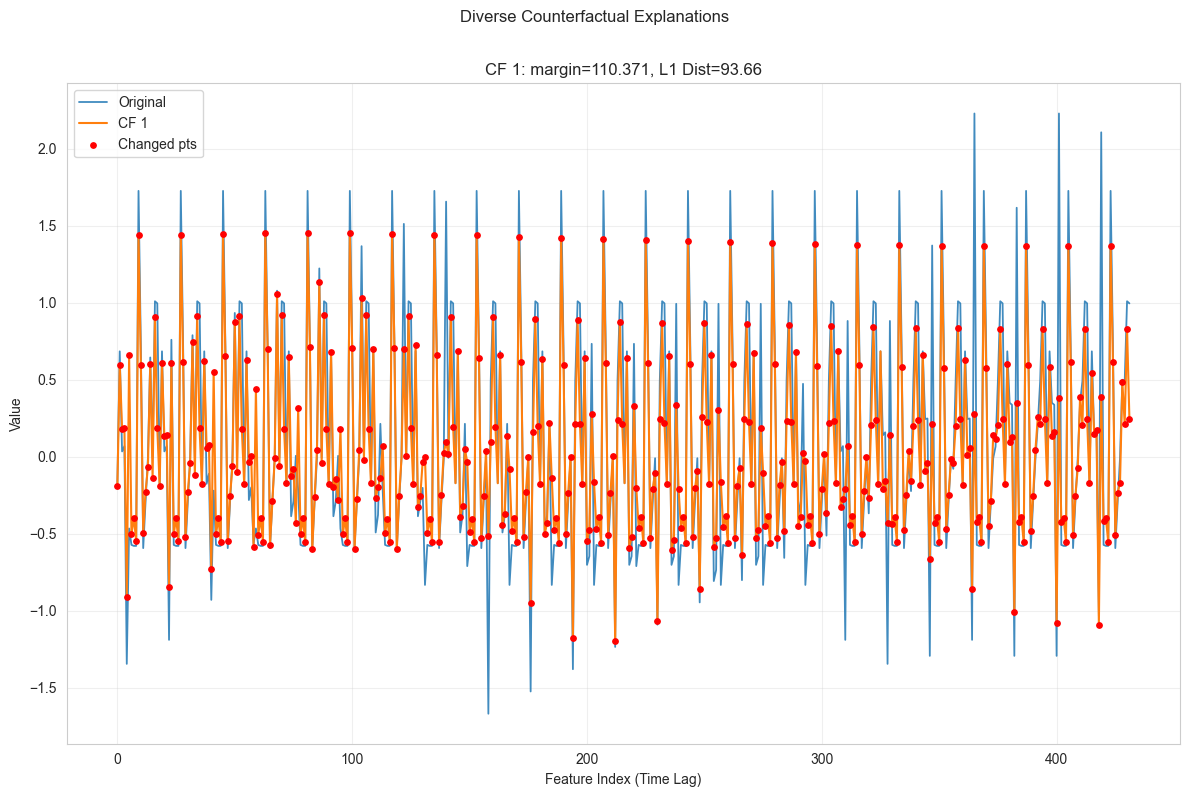

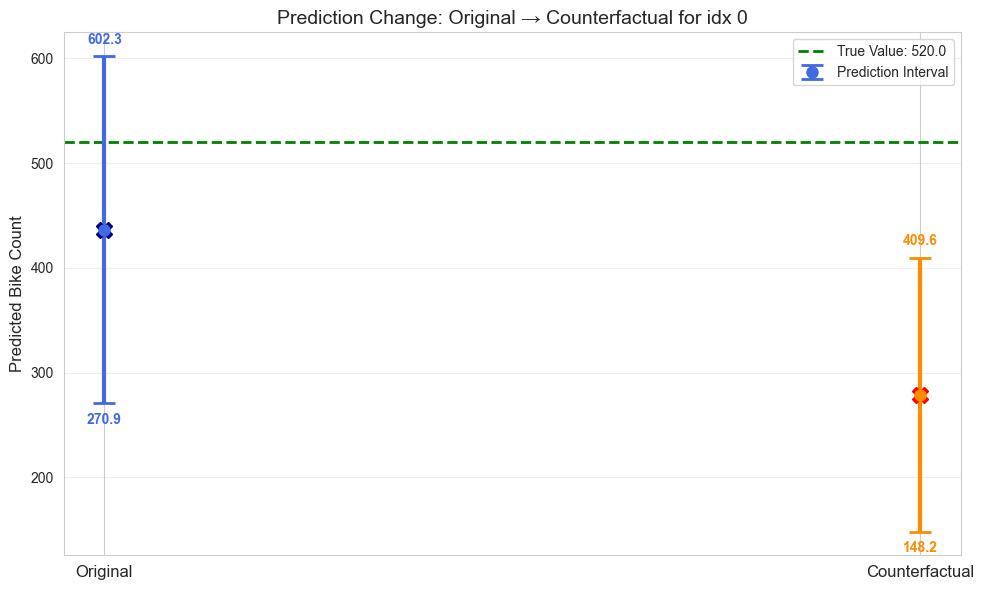

In [16]:
# === Counterfactual-selection-to-hit-coverage-target ===
import copy
import time

def generate_counterfactuals_until_target(
    gen_cf,
    acpi_model,
    X_eval,
    y_eval,
    covered_mask=None,
    alpha_prime=0.2,
    max_attempts_per_instance=1,
    n_samples_per_attempt=2000,
    exploration_std=0.05,
    immutable_mask=None,
    lower_bounds=None,
    upper_bounds=None,
    prioritize='covered_first',  # 'covered_first' or 'random'
    max_instances_to_modify=None,
    verbose=True
):
    """
    Iteratively generate single counterfactuals and substitute them into X_eval
    until empirical coverage across the dataset falls below 1 - alpha_prime.

    Returns:
      modified_X: copy of X_eval with substituted counterfactuals for selected instances
      selected_cfs: list of dicts with metadata for each selected CF
      final_coverage: coverage after substitutions
      attempts: total attempts made
    """
    # defensive copies
    X_mod = X_eval.copy().astype(np.float32)
    N = len(y_eval)
    target_coverage = 1.0 - alpha_prime

    # compute initial intervals and coverage
    lower_all, upper_all = acpi_model.predict_pi(X_mod, method='qrf')
    initial_coverage = float(np.mean((y_eval >= lower_all) & (y_eval <= upper_all)))
    if verbose:
        print(f"Initial coverage: {initial_coverage:.4f}, target < {target_coverage:.4f}")

    # build candidate order
    idxs = np.arange(N)
    if covered_mask is None:
        covered_mask = (y_eval >= lower_all) & (y_eval <= upper_all)

    covered_indices = idxs[covered_mask]
    uncovered_indices = idxs[~covered_mask]

    if prioritize == 'covered_first':
        order = list(covered_indices) + list(uncovered_indices)
    else:
        order = idxs.tolist()
        np.random.shuffle(order)

    selected_cfs = []
    attempts = 0
    start_time = time.time()

    # Limit how many instances we'll modify (optional)
    if max_instances_to_modify is None:
        max_instances_to_modify = len(order)

    for i_idx, idx in enumerate(order):
        if len(selected_cfs) >= max_instances_to_modify:
            break

        # Recompute coverage (so we use latest X_mod)
        lower_all, upper_all = acpi_model.predict_pi(X_mod, method='qrf')
        curr_coverage = float(np.mean((y_eval >= lower_all) & (y_eval <= upper_all)))
        if verbose:
            print(f"[iter {i_idx:03d}] idx={idx}, current coverage={curr_coverage:.4f}, selected={len(selected_cfs)}")
        # check stop condition
        if curr_coverage < target_coverage:
            if verbose:
                print(f"Target reached: coverage {curr_coverage:.4f} < {target_coverage:.4f}")
            break

        # Skip if this index already not covered and we don't want to change uncovered ones first
        # (we still may attempt since changing an uncovered instance might increase coverage)
        # We'll attempt only up to max_attempts_per_instance times to find a CF for this idx.
        attempts_for_this = 0
        success_cf = None
        while attempts_for_this < max_attempts_per_instance:
            attempts += 1
            attempts_for_this += 1

            gen_result = gen_cf.generate_diverse(
                X_eval[idx],
                y_eval[idx],
                n_samples=n_samples_per_attempt,
                exploration_std=exploration_std,
                lower_bounds=lower_bounds,
                upper_bounds=upper_bounds,
                immutable_mask=immutable_mask
            )

            if gen_result.get("status") != "success":
                if verbose:
                    print(f"  attempt {attempts_for_this}: no CFs found for idx {idx}")
                # try next attempt (if any)
                continue

            # Pick the minimal-L1-distance CF (smallest l1_distance)
            cfs = gen_result["counterfactuals"]
            cfs_sorted = sorted(cfs, key=lambda c: c["l1_distance"])
            chosen = cfs_sorted[0]
            chosen_x = chosen["x_cf"].astype(np.float32).reshape(1, -1)

            # Verify that replacing this sample indeed causes y_i not in C(x'_i)
            l_new, u_new = acpi_model.predict_pi(chosen_x, method='qrf')
            y_i = y_eval[idx]
            is_now_outside = not (l_new[0] <= y_i <= u_new[0])

            if not is_now_outside:
                # Sometimes generate_diverse may return CFs that are marginal or rounding issues;
                # skip such CFs (but keep trying other attempts).
                if verbose:
                    print(f"  attempt {attempts_for_this}: picked CF did NOT exclude y (numerical). skipping.")
                continue

            # Accept CF: substitute into X_mod and log metadata
            old_x = X_mod[idx].copy()
            X_mod[idx] = chosen_x
            cf_meta = dict(
                idx=idx,
                x_orig=old_x,
                x_cf=chosen_x.flatten(),
                l_old=float(lower_all[idx]),
                u_old=float(upper_all[idx]),
                l_new=float(l_new[0]),
                u_new=float(u_new[0]),
                y_true=float(y_i),
                margin=chosen.get("margin", None),
                l1=chosen.get("l1_distance", None),
                l2=chosen.get("l2_distance", None),
                gen_result_count=gen_result.get("n_successful", None),
                timestamp=time.time()
            )
            selected_cfs.append(cf_meta)
            if verbose:
                print(f"  SUCCESS: chosen CF for idx {idx} (L1={cf_meta['l1']:.3f}) -> new interval [{cf_meta['l_new']:.2f}, {cf_meta['u_new']:.2f}]")
            break  # move to next candidate index

        # continue main loop; coverage will be recomputed at top of loop
    total_time = time.time() - start_time
    final_lower, final_upper = acpi_model.predict_pi(X_mod, method='qrf')
    final_coverage = float(np.mean((y_eval >= final_lower) & (y_eval <= final_upper)))

    if verbose:
        print("-" * 60)
        print(f"Done. Attempts: {attempts}. Selected CFs: {len(selected_cfs)}. Final coverage: {final_coverage:.4f}. Time: {total_time:.1f}s")

    return X_mod, selected_cfs, final_coverage, attempts

# === Example usage ===
# Set the new coverage target param alpha' (user sets this)
# Compute current empirical coverage
lower_all, upper_all = acpi_model.predict_pi(X_test_acpi, method='qrf')
current_coverage = float(np.mean((y_test_acpi >= lower_all) & (y_test_acpi <= upper_all)))

# Set alpha_prime to be 1% lower than current coverage
alpha_prime = 1.0 - (current_coverage - 0.01)
target_coverage = 1.0 - alpha_prime

# Optional: constraints (match the scale of your features)
# If you trained VAE on normalized data with mean_X/std_X stored in gen_cf,
# the generate_diverse expects denormalized bounds (same scale as original features).
lower_bounds = None  # e.g., np.full(X_test_acpi.shape[1], -2.0)
upper_bounds = None
immutable_mask = None  # e.g., boolean mask of features that shouldn't change

# Run the iterative selection routine
X_modified, selected_cfs, final_coverage, attempts = generate_counterfactuals_until_target(
    gen_cf=gen_cf,
    acpi_model=acpi_model,
    X_eval=X_test_acpi,
    y_eval=y_test_acpi,
    covered_mask=None,                 # auto-computed from current intervals
    alpha_prime=alpha_prime,
    max_attempts_per_instance=1,       # tune: try more attempts if generator is flaky
    n_samples_per_attempt=3000,        # fewer or more depending on compute
    exploration_std=0.05,
    lower_bounds=lower_bounds,
    upper_bounds=upper_bounds,
    immutable_mask=immutable_mask,
    prioritize='covered_first',
    max_instances_to_modify=100,       # limit how many instances to change
    verbose=True
)

# Inspect results
print(f"Selected {len(selected_cfs)} counterfactuals. Final coverage: {final_coverage:.4f}")
for i, cf in enumerate(selected_cfs[:10]):
    print(f"CF {i+1}: idx={cf['idx']}, l_old={cf['l_old']:.2f}, u_old={cf['u_old']:.2f} -> l_new={cf['l_new']:.2f}, u_new={cf['u_new']:.2f}, l1={cf['l1']:.3f}")

# (Optional) visualize the first selected CF
if len(selected_cfs) > 0:
    first = selected_cfs[0]
    gen_cf.plot_diverse_counterfactuals({
        "status":"success",
        "x_orig": first["x_orig"],
        "counterfactuals": [{"x_cf": first["x_cf"], "margin": first.get("margin",0.0),
                             "l1_distance": first.get("l1",0.0), "l2_distance": first.get("l2",0.0)}],
        "y_true": first["y_true"]
    }, max_plot=1)
    # And plot prediction change
    plot_prediction_changes_generative(acpi_model, first["x_orig"], first["x_cf"], first["y_true"], instance_name=f"idx {first['idx']}")
